# Custom Components Tutorial

This tutorial demonstrates how to create **custom datasets**, **custom models**, and **custom loss functions** for use with the `statphys-ml` simulation framework.

## Table of Contents
1. [Overview](#1-overview)
2. [Custom Dataset](#2-custom-dataset)
3. [Custom Model](#3-custom-model)
4. [Custom Loss Function](#4-custom-loss-function)
5. [Running Simulation with Custom Components](#5-running-simulation-with-custom-components)
6. [Summary](#6-summary)

## 1. Overview

The `statphys-ml` package is designed to be extensible. You can create your own:

- **Datasets**: Custom data generation for teacher-student models
- **Models**: Custom neural network architectures
- **Loss Functions**: Custom objectives with regularization

All custom components inherit from base classes and follow a consistent interface.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import statphys
from statphys.utils import fix_seed

# Fix seed for reproducibility
fix_seed(42)

print(f"StatPhys-ML version: {statphys.__version__}")

StatPhys-ML version: 0.1.0


---
## 2. Custom Dataset

To create a custom dataset, inherit from `BaseDataset` and implement:
- `generate_sample()`: Generate a single (x, y) pair
- `get_teacher_params()`: Return teacher parameters for order parameter computation

### Example: Polynomial Teacher Dataset

Let's create a dataset where the teacher is a polynomial function:
$$y = w_0^\top x + w_1^\top (x \odot x) + \epsilon$$

In [2]:
from statphys.dataset.base import BaseDataset
from typing import Any


class PolynomialTeacherDataset(BaseDataset):
    """
    Dataset with polynomial teacher: y = w0'x + w1'(x⊙x) + noise
    
    This is a simple nonlinear teacher-student setup.
    """
    
    def __init__(
        self,
        d: int,
        rho_linear: float = 1.0,    # Norm of linear weights
        rho_quadratic: float = 0.5,  # Norm of quadratic weights
        eta: float = 0.1,            # Noise variance
        device: str = "cpu",
        **kwargs: Any,
    ):
        super().__init__(d=d, device=device, **kwargs)
        
        self.rho_linear = rho_linear
        self.rho_quadratic = rho_quadratic
        self.eta = eta
        
        # Initialize teacher weights
        # Linear weights: ||w0||^2 / d = rho_linear
        self.W0 = torch.randn(d, 1, device=self.device, dtype=self.dtype)
        self.W0 = self.W0 / torch.norm(self.W0) * np.sqrt(d * rho_linear)
        
        # Quadratic weights: ||w1||^2 / d = rho_quadratic
        self.W1 = torch.randn(d, 1, device=self.device, dtype=self.dtype)
        self.W1 = self.W1 / torch.norm(self.W1) * np.sqrt(d * rho_quadratic)
        
        # Store teacher parameters
        self._teacher_params = {
            "W0": self.W0,
            "W1": self.W1,
            "rho_linear": rho_linear,
            "rho_quadratic": rho_quadratic,
            "rho": rho_linear,  # For compatibility
            "eta": eta,
        }
    
    def generate_sample(self) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Generate a single sample.
        
        Returns:
            x: Input of shape (d,)
            y: Output (scalar)
        """
        # Generate Gaussian input
        x = torch.randn(self.d, device=self.device, dtype=self.dtype) / np.sqrt(self.d)
        
        # Compute teacher output
        linear_part = (x @ self.W0).squeeze()      # w0'x
        quadratic_part = ((x * x) @ self.W1).squeeze()  # w1'(x⊙x)
        
        # Add noise
        noise = torch.randn(1, device=self.device, dtype=self.dtype).squeeze() * np.sqrt(self.eta)
        
        y = linear_part + quadratic_part + noise
        
        return x, y
    
    def get_teacher_params(self) -> dict[str, Any]:
        """
        Return teacher parameters.
        
        These are used for computing order parameters.
        """
        return self._teacher_params
    
    def __repr__(self) -> str:
        return (f"PolynomialTeacherDataset(d={self.d}, "
                f"rho_linear={self.rho_linear}, "
                f"rho_quadratic={self.rho_quadratic}, "
                f"eta={self.eta})")

In [3]:
# Test the custom dataset
d = 100
custom_dataset = PolynomialTeacherDataset(
    d=d,
    rho_linear=1.0,
    rho_quadratic=0.3,
    eta=0.1,
)

print(f"Dataset: {custom_dataset}")
print(f"\nTeacher parameters:")
for key, value in custom_dataset.get_teacher_params().items():
    if isinstance(value, torch.Tensor):
        print(f"  {key}: shape={value.shape}, norm^2/d={torch.sum(value**2).item()/d:.4f}")
    else:
        print(f"  {key}: {value}")

# Generate samples
X, y = custom_dataset.generate_dataset(n_samples=200)
print(f"\nGenerated data: X.shape={X.shape}, y.shape={y.shape}")
print(f"y statistics: mean={y.mean():.4f}, std={y.std():.4f}")

Dataset: PolynomialTeacherDataset(d=100, rho_linear=1.0, rho_quadratic=0.3, eta=0.1)

Teacher parameters:
  W0: shape=torch.Size([100, 1]), norm^2/d=1.0000
  W1: shape=torch.Size([100, 1]), norm^2/d=0.3000
  rho_linear: 1.0
  rho_quadratic: 0.3
  rho: 1.0
  eta: 0.1

Generated data: X.shape=torch.Size([200, 100]), y.shape=torch.Size([200])
y statistics: mean=0.1017, std=1.0014


---
## 3. Custom Model

To create a custom model, inherit from `BaseModel` and implement:
- `forward()`: Forward pass
- `get_weight_vector()`: Return learnable weights as a flat tensor

### Example: Quadratic Model

A model that includes both linear and quadratic terms:
$$\hat{y} = w^\top x + v^\top (x \odot x)$$

In [4]:
from statphys.model.base import BaseModel


class QuadraticModel(BaseModel):
    """
    Model with linear and quadratic terms: y = w'x + v'(x⊙x)
    
    This model can learn both linear and quadratic patterns.
    """
    
    def __init__(
        self,
        d: int,
        init_scale: float = 0.01,
        **kwargs: Any,
    ):
        super().__init__(d=d, **kwargs)
        
        self.init_scale = init_scale
        
        # Linear weights
        self.W = nn.Parameter(torch.randn(d, 1) * init_scale)
        
        # Quadratic weights
        self.V = nn.Parameter(torch.randn(d, 1) * init_scale)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass.
        
        Args:
            x: Input of shape (batch, d) or (d,)
        
        Returns:
            Output of shape (batch,) or scalar
        """
        if x.dim() == 1:
            x = x.unsqueeze(0)
        
        # Linear part
        linear = (x @ self.W).squeeze(-1)  # (batch,)
        
        # Quadratic part: x⊙x
        quadratic = ((x * x) @ self.V).squeeze(-1)  # (batch,)
        
        output = linear + quadratic
        
        return output.squeeze() if output.shape[0] == 1 else output
    
    def get_weight_vector(self) -> torch.Tensor:
        """
        Get all weights as a single vector.
        
        We concatenate W and V for order parameter computation.
        """
        return torch.cat([self.W.flatten(), self.V.flatten()])
    
    def __repr__(self) -> str:
        return f"QuadraticModel(d={self.d}, params={self.num_parameters})"

In [5]:
# Test the custom model
custom_model = QuadraticModel(d=d)

print(f"Model: {custom_model}")
print(f"Number of parameters: {custom_model.num_parameters}")
print(f"  - Linear weights (W): {custom_model.W.numel()}")
print(f"  - Quadratic weights (V): {custom_model.V.numel()}")

# Test forward pass
x_test = torch.randn(10, d) / np.sqrt(d)
y_pred = custom_model(x_test)
print(f"\nForward pass: input shape={x_test.shape}, output shape={y_pred.shape}")

Model: QuadraticModel(d=100, params=200)
Number of parameters: 200
  - Linear weights (W): 100
  - Quadratic weights (V): 100

Forward pass: input shape=torch.Size([10, 100]), output shape=torch.Size([10])


---
## 4. Custom Loss Function

To create a custom loss, inherit from `BaseLoss` and implement:
- `_compute_loss()`: Compute the main loss term (without reduction)

The base class handles:
- Reduction (mean, sum, none)
- Regularization computation

### Example: Robust Huber-like Loss with Custom Threshold

In [6]:
from statphys.loss.base import BaseLoss


class CustomRobustLoss(BaseLoss):
    """
    A custom robust loss that smoothly transitions between MSE and absolute error.
    
    L(r) = {
        r^2 / 2                        if |r| < delta
        delta * |r| - delta^2 / 2      otherwise
    }
    
    This is similar to Huber loss but with customizable parameters.
    """
    
    def __init__(
        self,
        delta: float = 1.0,
        reg_param: float = 0.0,
        reduction: str = "mean",
        **kwargs: Any,
    ):
        super().__init__(reg_param=reg_param, reduction=reduction, **kwargs)
        self.delta = delta
    
    def _compute_loss(
        self,
        y_pred: torch.Tensor,
        y_true: torch.Tensor,
    ) -> torch.Tensor:
        """
        Compute the robust loss.
        
        Args:
            y_pred: Predictions
            y_true: True values
        
        Returns:
            Loss tensor (unreduced)
        """
        residual = y_pred - y_true
        abs_residual = torch.abs(residual)
        
        # Quadratic region: |r| < delta
        quadratic = 0.5 * residual**2
        
        # Linear region: |r| >= delta
        linear = self.delta * abs_residual - 0.5 * self.delta**2
        
        # Smooth selection
        loss = torch.where(abs_residual < self.delta, quadratic, linear)
        
        return loss
    
    def __repr__(self) -> str:
        return f"CustomRobustLoss(delta={self.delta}, reg_param={self.reg_param})"

Loss: CustomRobustLoss(delta=0.5, reg_param=0.01)


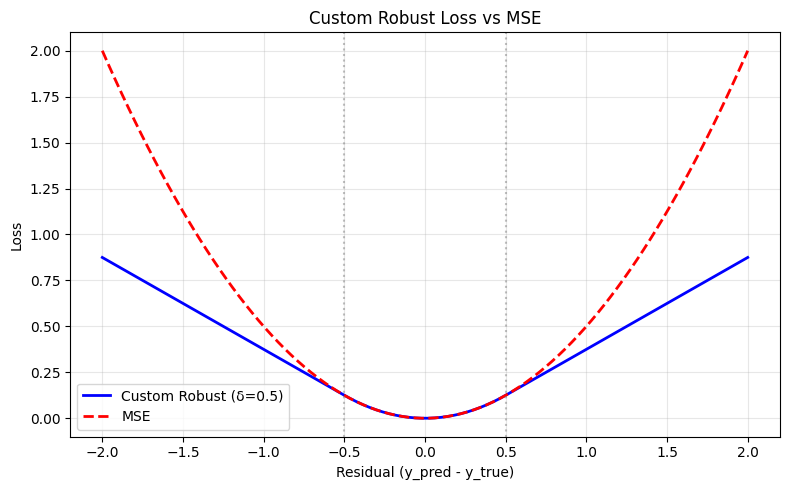

In [7]:
# Test the custom loss
custom_loss = CustomRobustLoss(delta=0.5, reg_param=0.01)

print(f"Loss: {custom_loss}")

# Compare behavior for different residuals
residuals = torch.linspace(-2, 2, 100)
y_pred = residuals
y_true = torch.zeros_like(residuals)

# Compute losses without model (no regularization)
loss_values = custom_loss._compute_loss(y_pred, y_true)

# Also compute MSE for comparison
mse_values = 0.5 * residuals**2

# Plot comparison
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(residuals.numpy(), loss_values.numpy(), 'b-', linewidth=2, label=f'Custom Robust (δ={custom_loss.delta})')
ax.plot(residuals.numpy(), mse_values.numpy(), 'r--', linewidth=2, label='MSE')
ax.axvline(x=custom_loss.delta, color='gray', linestyle=':', alpha=0.5)
ax.axvline(x=-custom_loss.delta, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Residual (y_pred - y_true)')
ax.set_ylabel('Loss')
ax.set_title('Custom Robust Loss vs MSE')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 5. Running Simulation with Custom Components

Now let's use all our custom components together in a simulation!

### Important: Custom Order Parameters Function

When using custom models, you need to provide a custom `calc_order_params` function that computes the order parameters specific to your model.

In [8]:
def custom_order_params(dataset, model) -> list[float]:
    """
    Custom function to compute order parameters for QuadraticModel.
    
    This function is called after training and receives:
    - dataset: The dataset instance
    - model: The trained model instance
    
    Returns:
        List of order parameter values: [m_linear, m_quad, q_linear, q_quad, eg]
    """
    teacher_params = dataset.get_teacher_params()
    W0 = teacher_params["W0"]
    W1 = teacher_params["W1"]
    rho_l = teacher_params["rho_linear"]
    rho_q = teacher_params["rho_quadratic"]
    eta = teacher_params["eta"]
    d = dataset.d
    
    # Get model weights
    W = model.W.detach()
    V = model.V.detach()
    
    # Compute overlaps
    m_linear = (W.flatten() @ W0.flatten()).item() / d
    m_quad = (V.flatten() @ W1.flatten()).item() / d
    q_linear = torch.sum(W**2).item() / d
    q_quad = torch.sum(V**2).item() / d
    
    # Generalization error estimate
    eg = 0.5 * (rho_l + q_linear - 2 * m_linear)
    eg += 0.5 * (rho_q + q_quad - 2 * m_quad)
    eg += 0.5 * eta
    
    return [m_linear, m_quad, q_linear, q_quad, eg]


print("Custom order parameter function defined.")
print("Returns: [m_linear, m_quad, q_linear, q_quad, eg]")

Custom order parameter function defined.
Returns: [m_linear, m_quad, q_linear, q_quad, eg]


In [9]:
from statphys.simulation import ReplicaSimulation, SimulationConfig

# Configuration
d = 200  # Input dimension
fix_seed(42)

print("="*60)
print("Simulation with Custom Components")
print("="*60)

Simulation with Custom Components


In [10]:
# Step 1: Create custom dataset
print("\n[Step 1] Creating custom dataset...")
dataset = PolynomialTeacherDataset(
    d=d,
    rho_linear=1.0,
    rho_quadratic=0.3,
    eta=0.1,
)
print(f"  {dataset}")


[Step 1] Creating custom dataset...
  PolynomialTeacherDataset(d=200, rho_linear=1.0, rho_quadratic=0.3, eta=0.1)


In [11]:
# Step 2: Create custom loss
print("\n[Step 2] Creating custom loss...")
loss_fn = CustomRobustLoss(delta=0.5, reg_param=0.01)
print(f"  {loss_fn}")


[Step 2] Creating custom loss...
  CustomRobustLoss(delta=0.5, reg_param=0.01)


In [12]:
# Step 3: Configure simulation
print("\n[Step 3] Configuring simulation...")
config = SimulationConfig.for_replica(
    alpha_range=(0.5, 4.0),
    alpha_steps=8,
    n_seeds=3,
    lr=0.01,
    max_iter=10000,
    tol=1e-5,
    patience=50,
    reg_param=0.01,
    verbose=True,
    verbose_interval=5000,
)
print(f"  Alpha range: {config.alpha_range}")
print(f"  Alpha steps: {config.alpha_steps}")
print(f"  Seeds: {config.n_seeds}")


[Step 3] Configuring simulation...
  Alpha range: (0.5, 4.0)
  Alpha steps: 8
  Seeds: 3


In [13]:
# Step 4: Run simulation with custom order params function
print("\n[Step 4] Running simulation...")
sim = ReplicaSimulation(config)

results = sim.run(
    dataset=dataset,
    model_class=QuadraticModel,           # Custom model class
    loss_fn=loss_fn,                      # Custom loss instance
    calc_order_params=custom_order_params,  # Custom order params function!
)

print("\n  Simulation complete!")


[Step 4] Running simulation...
【TRIAL 1/3, SEED 100】


  α=0.50: Converged at iteration 67
  α=1.00: Converged at iteration 58


  α=1.50: Converged at iteration 54
  α=2.00: Converged at iteration 52
  α=2.50: Converged at iteration 51


  α=3.00: Converged at iteration 51


  α=3.50: Converged at iteration 51


  α=4.00: Converged at iteration 51
【TRIAL 2/3, SEED 101】
  α=0.50: Converged at iteration 67


  α=1.00: Converged at iteration 59
  α=1.50: Converged at iteration 53
  α=2.00: Converged at iteration 51


  α=2.50: Converged at iteration 51
  α=3.00: Converged at iteration 51


  α=3.50: Converged at iteration 51
  α=4.00: Converged at iteration 51
【TRIAL 3/3, SEED 102】
  α=0.50: Converged at iteration 66


  α=1.00: Converged at iteration 58
  α=1.50: Converged at iteration 54
  α=2.00: Converged at iteration 52


  α=2.50: Converged at iteration 51
  α=3.00: Converged at iteration 51


  α=3.50: Converged at iteration 51
  α=4.00: Converged at iteration 51

  Simulation complete!



[Step 5] Visualizing results...
  Order params shape: (8, 5)
  Order params: [m_linear, m_quad, q_linear, q_quad, eg]


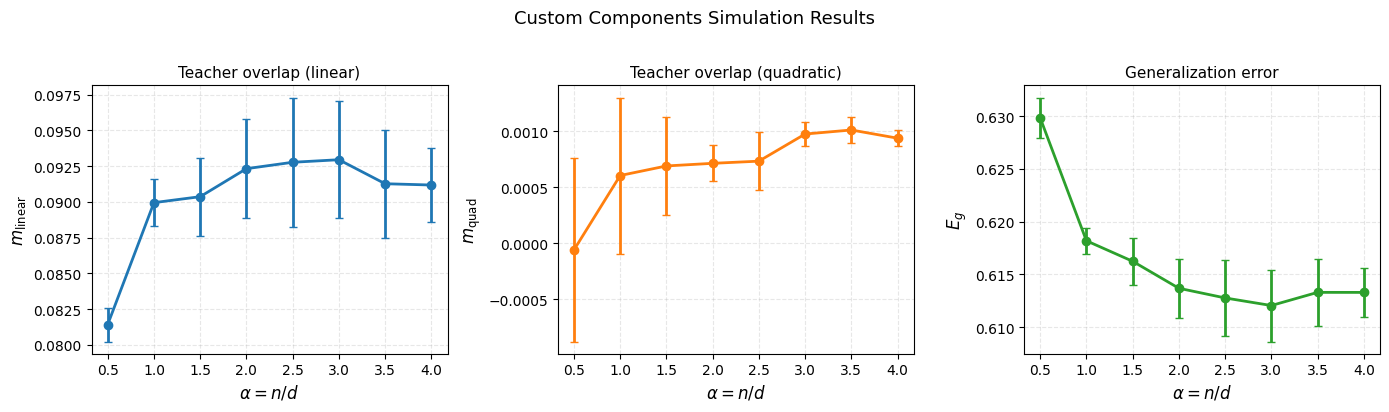

In [14]:
# Step 5: Visualize results
print("\n[Step 5] Visualizing results...")

alpha_values = np.array(results.experiment_results["alpha_values"])
op_mean = np.array(results.experiment_results["order_params_mean"])
op_std = np.array(results.experiment_results["order_params_std"])

print(f"  Order params shape: {op_mean.shape}")
print(f"  Order params: [m_linear, m_quad, q_linear, q_quad, eg]")

# Plot order parameters
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Order params are: [m_linear, m_quad, q_linear, q_quad, eg]
param_info = [
    (0, r"$m_{\mathrm{linear}}$", "Teacher overlap (linear)"),
    (1, r"$m_{\mathrm{quad}}$", "Teacher overlap (quadratic)"),
    (4, r"$E_g$", "Generalization error"),
]

colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

for ax, (idx, label, title), color in zip(axes, param_info, colors):
    ax.errorbar(
        alpha_values,
        op_mean[:, idx],
        yerr=op_std[:, idx],
        marker='o',
        capsize=3,
        color=color,
        linewidth=2,
        markersize=6,
    )
    ax.set_xlabel(r"$\alpha = n/d$", fontsize=12)
    ax.set_ylabel(label, fontsize=12)
    ax.set_title(title, fontsize=11)
    ax.grid(True, linestyle='--', alpha=0.3)

plt.suptitle("Custom Components Simulation Results", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

In [15]:
# Print summary
print("\n" + "="*60)
print("Summary")
print("="*60)

print("\nOrder Parameters at different α:")
for i in range(0, len(alpha_values), 2):
    print(f"\n  α = {alpha_values[i]:.2f}:")
    print(f"    m_linear    = {op_mean[i, 0]:.4f} ± {op_std[i, 0]:.4f}")
    print(f"    m_quadratic = {op_mean[i, 1]:.4f} ± {op_std[i, 1]:.4f}")
    print(f"    E_g         = {op_mean[i, 4]:.4f} ± {op_std[i, 4]:.4f}")


Summary

Order Parameters at different α:

  α = 0.50:
    m_linear    = 0.0814 ± 0.0012
    m_quadratic = -0.0001 ± 0.0008
    E_g         = 0.6298 ± 0.0019

  α = 1.50:
    m_linear    = 0.0904 ± 0.0027
    m_quadratic = 0.0007 ± 0.0004
    E_g         = 0.6162 ± 0.0022

  α = 2.50:
    m_linear    = 0.0928 ± 0.0045
    m_quadratic = 0.0007 ± 0.0003
    E_g         = 0.6128 ± 0.0036

  α = 3.50:
    m_linear    = 0.0913 ± 0.0038
    m_quadratic = 0.0010 ± 0.0001
    E_g         = 0.6133 ± 0.0031


---
## 6. Summary

### Creating Custom Components

| Component | Base Class | Required Methods |
|-----------|------------|------------------|
| **Dataset** | `BaseDataset` | `generate_sample()`, `get_teacher_params()` |
| **Model** | `BaseModel` | `forward()`, `get_weight_vector()` |
| **Loss** | `BaseLoss` | `_compute_loss()` |

### Key Points

1. **Datasets** should store teacher parameters in `_teacher_params` for order parameter computation

2. **Models** need `forward()` and `get_weight_vector()` methods

3. **Losses** get reduction and regularization handling for free from the base class

4. **Simulations** accept:
   - `model_class`: A class (not instance) that takes `d` as first argument
   - `loss_fn`: An instance of a loss function
   - `calc_order_params`: **Required for custom models** - function returning list of floats

### Template for Custom Components

```python
# Custom Dataset
class MyDataset(BaseDataset):
    def generate_sample(self):
        # Return (x, y) tuple
        pass
    
    def get_teacher_params(self):
        return self._teacher_params

# Custom Model
class MyModel(BaseModel):
    def forward(self, x):
        # Return predictions
        pass
    
    def get_weight_vector(self):
        return self.W.flatten()

# Custom Loss
class MyLoss(BaseLoss):
    def _compute_loss(self, y_pred, y_true):
        # Return unreduced loss tensor
        return (y_pred - y_true)**2

# Custom Order Params Function
def my_order_params(dataset, model) -> list[float]:
    # Compute and return list of order parameters
    return [m, q, eg]
```

In [16]:
print("Tutorial complete!")
print("\nYou now know how to:")
print("  ✓ Create custom datasets with any teacher function")
print("  ✓ Create custom models with any architecture")
print("  ✓ Create custom loss functions with any objective")
print("  ✓ Define custom order parameter functions")
print("  ✓ Run simulations with all custom components")

Tutorial complete!

You now know how to:
  ✓ Create custom datasets with any teacher function
  ✓ Create custom models with any architecture
  ✓ Create custom loss functions with any objective
  ✓ Define custom order parameter functions
  ✓ Run simulations with all custom components
